In [14]:
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt

def Lloyd(k, N, d, m, dist, x, tol):
    def is_close(prev_m, m, tol):
        norm = 0
        for i in range(k):
            for j in range(d):
                norm += abs(m[i][j] - prev_m[i][j])
        return norm < tol
        
    prev_m = m
    obj_f = sum([sum([dist(x[i], m[j]) for i in range(N)]) for j in range(k)])
    t = 0
    c = [i for i in range(N)]
    while t == 0 or (is_close(prev_m, m, tol) and t < 1000):
        t += 1
        
        prev_m = copy.deepcopy(m)
        
        p = np.zeros([N,k])
        c_count = np.zeros(k)
        for i in range(N):
            assignment = np.argmin([dist(x[i],m[j]) for j in range(k)])
            p[i][assignment] = 1
            c[i] = assignment
            c_count[assignment] += 1
        
        m = np.array([1/c_count[j]*sum([x[i]*p[i][j] for i in range(N)]) for j in range(k)])
        
    obj_f = sum([sum([dist(x[i], m[j]) for i in range(N)]) for j in range(k)])
    return (m, c, obj_f)

In [3]:
def GreedyKCenters(k, N, d, dist, x, c1):
    def two_norm(x, y):
        distance = 0
        for i in range(d):
            distance += (x[i] - y[i]) ** 2
        return distance ** 0.5
    def in_c (x, c):
        for i in c:
            if np.array_equal(x,i):
                return True
        return False
    c = [c1]
    while len(c) < k:
        distances = []
        for j in range(N):
            if not in_c (x[j], c):
                distances.append(sum([dist(i, x[j]) for i in c]))
            else:
                distances.append(0)

        xl = x[np.argmax(distances)]
        c.append(xl)
    obj_f = max([min([two_norm(i, j) for j in c]) for i in x])

    return (np.array(c), obj_f)

In [27]:
def SingleSwap(k, N, d, dist, x, c, obj_f, tau, tol):
    def two_norm(x, y):
        distance = 0
        for i in range(d):
            distance += (x[i] - y[i]) ** 2
        return distance ** 0.5
    def in_array (x, c):
        for i in c:
            if np.array_equal(x,i):
                return True
        return False

    p = np.zeros([N,k])
    for i in range(N):
        assignment = np.argmin([dist(x[i],c[j]) for j in range(k)])
        p[i][assignment] = 1
    cost = sum([sum([dist(x[i], c[j])*p[i][j] for i in range(N)]) for j in range(k)])
    
    t = 0
    while t < min(tol,N):
        t += 1
               
        x_exclude_c = [x[i] for i in range(N) if not in_array(x[i],c)]
        in_idx = np.random.choice([i for i in range(N - k)],1)[0]
        xi = x_exclude_c[in_idx]
        
        out_idx = np.random.choice([i for i in range(k)],1)[0]
        mj = c[out_idx] 
        
        new_c = [xi]
        for i in range(k):
            if np.array_equal(c[i],mj):
                new_c.append(mj)
        
        p = np.zeros([N,k])
        for i in range(N):
            assignment = np.argmin([dist(x[i],new_c[j]) for j in range(k)])
            p[i][assignment] = 1
        new_cost = sum([sum([dist(x[i], new_c[j])*p[i][j] for i in range(N)]) for j in range(k)])
        
        if cost - 10**(1 - tau) > new_cost:
            c = new_c    
            cost = new_cost
            t = 0
        
    obj_f = max([min([two_norm(i, j) for j in new_c]) for i in x])
    
    return (np.array(c), obj_f)

In [28]:
import csv
import random


with open('C:/Users/ericp/Desktop/clustering.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    x = list(reader)
    x = np.array(x).astype("float")

k = 2
N = len(x)
d = len(x[0])

def dist(p1,p2):
    distance = 0
    for i in range(len(p1)):
        distance += (p1[i] - p2[i])**2
    return distance


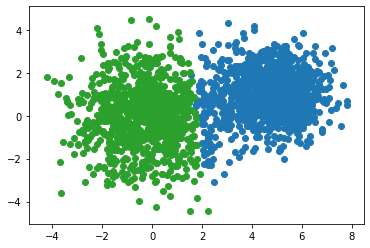

In [34]:
idxs = [i for i in range(N)]
random.shuffle(idxs)
idxs = idxs[:k]
m = []
for i in idxs:
    m.append(x[i])
m = np.array(m)

Lloyd_result = Lloyd(k, N, d, m, dist, x, 1e-3)

C = [np.argmin([dist(i, j) for j in Lloyd_result[0]]) for i in x]
fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:green']
for i in range(k):
    for j in range(N):
        if C[j] == i:
            ax.scatter(x[j][0], x[j][1], c=colors[i])
plt.show()

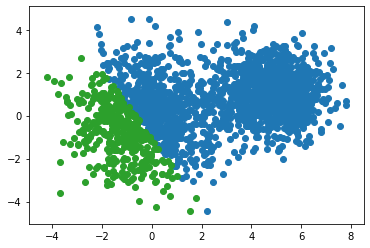

In [261]:
idxs = [i for i in range(N)]
random.shuffle(idxs)
idxs = idxs[:k]
m = []
for i in idxs:
    m.append(x[i])
m = np.array(m)

c1 = x[idxs[0]]
Greedyk_result = GreedyKCenters(k, N, d, dist, x, c1)

C = [np.argmin([dist(i, j) for j in Greedyk_result[0]]) for i in x]
fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:green']
for i in range(k):
    for j in range(N):
        if C[j] == i:
            ax.scatter(x[j][0], x[j][1], c=colors[i])
plt.show()

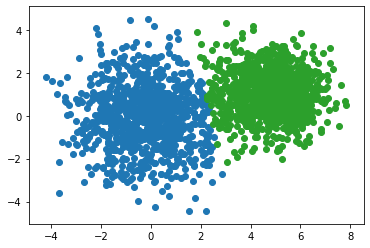

In [292]:
SingleSwap_result = SingleSwap(k, N, d, dist, x, Greedyk_result[0], Greedyk_result[1], 0.05, 100)
C = [np.argmin([dist(i, j) for j in SingleSwap_result[0]]) for i in x]
fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:green']
for i in range(k):
    for j in range(N):
        if C[j] == i:
            ax.scatter(x[j][0], x[j][1], c=colors[i])
plt.show()

In [147]:
def Spectral(k, N, d, dist, x, sigma):
    def two_norm(x, y):
        distance = 0
        for i in range(len(x)):
            distance += (x[i] - y[i]) ** 2
        return distance ** 0.5

    W = np.zeros([N, N])
    for i in range(N):
        '''
        for j in range(N):
            W[i][j] = dist(x[i], x[j], sigma) #fully connected graph
        '''
        distances = sorted([(dist(x[i], x[j], sigma), j) for j in range(N)], key=lambda x:x[0])[::-1][1:k+1]
        for point in distances:
            W[i][point[1]] = 1
            W[point[1]][i] = 1

    D = np.diag([sum([j for j in i]) for i in W])
    L = np.add(D, -W)

    eigenValues, eigenVectors = np.linalg.eig(L)

    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    U = eigenVectors[:,:k]
    y = np.array([i for i in U])

    idxs = [i for i in range(N)]
    random.shuffle(idxs)
    idxs = idxs[:k]
    m = []
    for i in idxs:
        m.append(y[i])
    m = np.array(m)

    good_start_idx = [0,1,14,25]
    m = np.array([y[i] for i in good_start_idx])

    Lloyd_result = Lloyd(k, len(y), len(y[0]), m, two_norm, y, 1e-5)

    C = [np.argmin([two_norm(i, j) for j in Lloyd_result[0]]) for i in y]
        
    return (W, U, C)

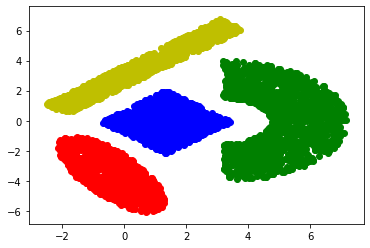

In [148]:
import csv
import random

with open('C:/Users/ericp/Desktop/ShapedData.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    x = list(reader)
    x = np.array(x).astype("float")

k = 4
N = len(x)
d = len(x[0])
sigma = 1

def dist(p1,p2,sigma):
    distance = 0
    for i in range(len(p1)):
        distance += (p1[i] - p2[i])**2
    return np.exp(-distance/(2*sigma**2))

Spectral_result = Spectral(k, N, d, dist, x, sigma)

fig, ax = plt.subplots()
colors = ['b','g','r','y']
for i in range(k):
    for j in range(N):
        if Spectral_result[2][j] == i:
            ax.scatter(x[j][0], x[j][1], c=colors[i])
plt.show()